In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import the MNIST dataset
import torchvision.datasets as datasets
from torchvision import transforms

import torchsummary

from sklearn.model_selection import train_test_split

# from torchdiffeq import odeint, odeint_adjoint

import cv2
import numpy as np

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from tqdm.notebook import trange

In [2]:
from utils import ConvAE, create_gaussian_dataset

In [3]:
r_min = 1.
r_max = 1.
n_samples = 5000
size = 28
samples = create_gaussian_dataset(r_min, r_max, n_samples, size)
samples = np.array([image for image, _ in samples])


# Split train and test data using sklearn
samples_train, samples_test = train_test_split(samples, test_size=0.3, random_state=42)
# create a dataloader from the matrix of samples

dataloader_train = DataLoader(samples_train, batch_size=128, shuffle=True)
dataloader_test = DataLoader(samples_test, batch_size=64, shuffle=False)

In [9]:
class HeatmapLoss(nn.Module):
    def __init__(self, scale=1., eps=1E-5):
        super().__init__()
        self.scale = scale
        self.eps = eps

    def forward(self, pred, gt):
        assert pred.size() == gt.size()
        pred = pred.float()
        gt = gt.float()
        
        scale = self.scale  
        dis = gt.clone()
        dis = torch.where(torch.gt(gt, self.eps), gt, gt + 1)
        dis = torch.log(dis).float()

        scaled_gt = gt + gt*dis*scale + 0.5*gt*dis**2*scale**2
        weight = torch.abs(1-pred) * gt ** 0.01 + torch.abs(pred) * (1 - gt**0.01)

        loss = (pred - scaled_gt)**2 * weight
        loss = loss.mean(dim=3).mean(dim=2).mean(dim=1).mean()

        return loss*100

loss_fn = HeatmapLoss(eps=1E-12, scale=0.5)

class GaussianLoss(nn.Module):
    def __init__(self, scale=1., eps=1E-5):
        super().__init__()
        self.scale = scale
        self.eps = eps
        self.mse = nn.MSELoss()

    def forward(self, pred, gt, mask):
        assert pred.size() == gt.size()
        pred = pred.float()
        gt = gt.float()
        mask = mask.float()

        loss = 0.1*torch.mean((((pred**2).mean(dim=((1,2,3))) - (gt**2).mean(dim=((1,2,3))).mean())**2)**2)
        loss += self.mse(pred, gt)

        return loss

loss_fn2 = GaussianLoss(eps=0, scale=1.0)

In [10]:
model = ConvAE(height=28, width=28, latent_dim=2)
model.load_state_dict(torch.load("models/AE/conv_custom_2_custom_loss_alpha_0_3.pt"))
# torchsummary.summary(model, input_size=(1, 28, 28))

Number of parameters in the model: 220387


<All keys matched successfully>

In [34]:
x = torch.tensor(np.expand_dims(samples[10], axis=0), dtype=torch.float32)
# We need to give to the loss the :
# - the prediction of the model
# - the ground truth
# - the mask
# - the scale=1
eps=0
gt = torch.tensor(np.expand_dims(samples[10], axis=0), dtype=torch.float32)
gt = gt
print(gt.shape)
pred = model(x)[0]
scale = 1
loss = loss_fn(pred, gt)
print(loss)



torch.Size([1, 1, 28, 28])
tensor(0.0004, grad_fn=<MeanBackward0>)


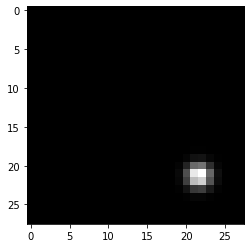

In [21]:
# plot the mask of the first sample
plt.imshow(samples[1,0], cmap='gray')

In [11]:
def train(model, dataloader_train, dataloader_test, optimizer, scheduler, criterion, epochs=10, display_step=1):
    
    iterator = trange(epochs)
    losses_train = []
    losses_test = []
    for _ in iterator:
        loss_epoch = 0
        model.train()
        for i, data in enumerate(dataloader_train):
            image = data
            # image is the ground truth
            image = image.float()
            # retrieve the mask
            optimizer.zero_grad()
            output, _ = model(image)
            loss = criterion(output, image)
            # print(loss.dtype, output.dtype, image.dtype, mask.dtype)
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
            if i % display_step == 0:
                iterator.set_description(f'Batch: {i}/{len(dataloader_train)}, Loss: {loss_epoch/(i+1):.6f}')
            

        losses_train.append(loss_epoch/len(dataloader_train))
        model.eval()
        with torch.no_grad():
            loss_epoch = 0
            for i, data in enumerate(dataloader_test):
                image = data
                image = image.float()
                # retrieve the mask
                optimizer.zero_grad()
                output, _ = model(image)
                loss = criterion(output, image)
                
                loss_epoch += loss.item()
                if i % display_step == 0:
                    iterator.set_postfix_str(f'Test Batch: {i}/{len(dataloader_test)}, Loss: {loss_epoch/(i+1):.6f}')
            
            losses_test.append(loss_epoch/len(dataloader_test))
            
        scheduler.step()
        
    return losses_train, losses_test

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.001) #, betas=(0.99,0.999), weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

In [13]:
losses_train, losses_test = train(
    model,
    dataloader_train,
    dataloader_test,
    optimizer,
    scheduler,
    loss_fn,
    epochs=1000,
    display_step=4
)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

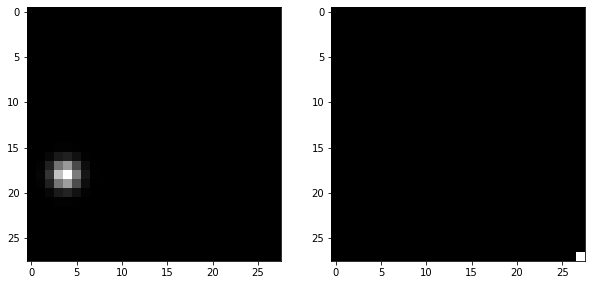

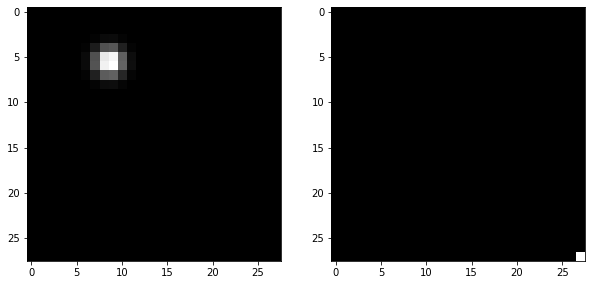

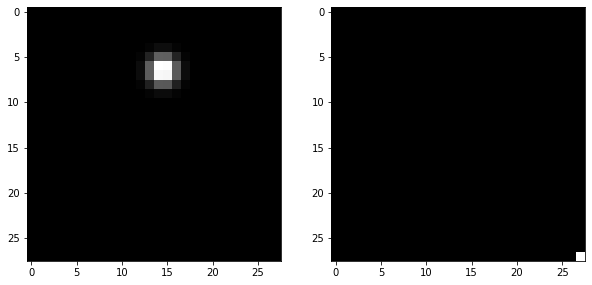

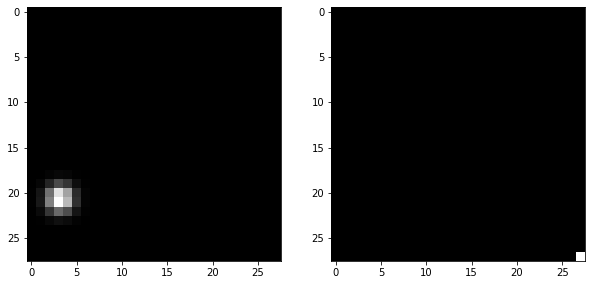

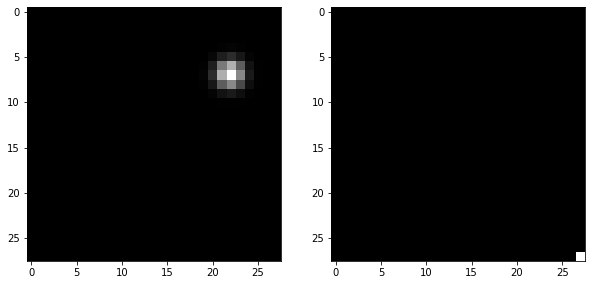

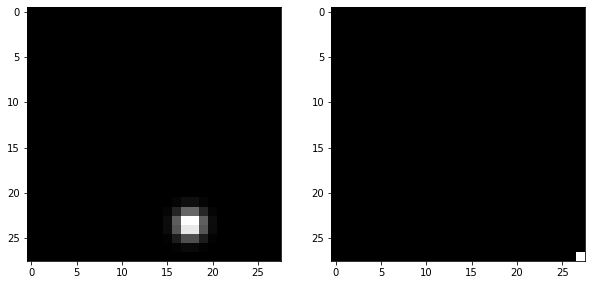

In [14]:
images = [image for image in samples_test]
for i, index in enumerate([0, len(images)//5, len(images)//4, len(images)//2, 3*len(images)//4, -1]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    pred_image, pred_position = model(torch.tensor(images[index]).float().unsqueeze(0))
    pred_image = pred_image.detach().numpy()
    pred_position = pred_position.detach().numpy()


    # print(f"Position predicted : {pred_position[0,:2]} | True position : {samples[index][1][:2]}")
    # print(f"Radius predicted : {pred_position[0,2]} | Radius position : {samples[index][1][2]}")
    ax[0].imshow(np.squeeze(images[index]), cmap='gray')
    ax[1].imshow(pred_image.squeeze(), cmap='gray')
    plt.show()